In [1]:
import sys
sys.path.append('/home/mmann1123/Documents/github/xr_fresh/')
import numpy as np
import dask.array as da
import xarray as xr
from xr_fresh.backends import Cluster
from xr_fresh.extractors import extract_features
from xr_fresh.transformers import Stackerizer 

from sklearn_xarray import wrap, Target
from sklearn_xarray.preprocessing import Splitter, Sanitizer, Featurizer
from sklearn_xarray.model_selection import CrossValidatorWrapper
from sklearn_xarray.datasets import load_wisdm_dataarray
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline


nrows = 100
ncols = 200
row_chunks = 50
col_chunks = 50

data = da.random.random(size=(1, nrows, ncols), chunks=(1, row_chunks, col_chunks))

def create_band(data, x, y, band_name):

    return xr.DataArray(data,
                        dims=('band', 'y', 'x'),
                        coords={'band': [band_name],
                                'y': y,
                                'x': x})

def create_coords(data, left, top, celly, cellx):
    nrows = data.shape[-2]
    ncols = data.shape[-1]
    right = left + cellx*ncols
    bottom = top - celly*nrows
    x = np.linspace(left, right, ncols) + cellx/2.0
    y = np.linspace(top, bottom, nrows) - celly/2.0
    
    return x, y

x, y = create_coords(data, 1000, 2000, 30, 30)

src = []

for time in ['t1', 't2', 't3']:

    src_t = xr.concat([create_band(data, x, y, band) for band in ['blue', 'green', 'red', 'nir']], dim='band')\
                    .expand_dims(dim='time')\
                    .assign_coords({'time': [time]})
    
    src.append(src_t)

src = xr.concat(src, dim='time')
src = src.chunk((len(src.time), 1, 350, 350))
src.attrs['nodatavals'] =  (-9999,)
print(src)

<xarray.DataArray 'random_sample-d231a0022a8a2b0f83654e199b970fee' (time: 3, band: 4, y: 100, x: 200)>
dask.array<rechunk-merge, shape=(3, 4, 100, 200), dtype=float64, chunksize=(3, 1, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * band     (band) object 'blue' 'green' 'red' 'nir'
  * y        (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * time     (time) object 't1' 't2' 't3'
Attributes:
    nodatavals:  (-9999,)


### Create time series features

In [3]:
%%time
complete_f =  {
                'abs_energy':[{}],       
                'mean_abs_change':[{}],  
                'variance_larger_than_standard_deviation':[{}],   
                'ratio_beyond_r_sigma':[{'r':1},{'r':2},{'r':3}],
                'large_standard_deviation':[{'r':0.5},{'r':1},{'r':2},{'r':3}],
                 'symmetry_looking':[{}],
                 'sum_values':[{}],
                 'autocorr':[{'lag':1},{'lag':2}],   
                 'ts_complexity_cid_ce':[{}],
                 'mean_change':[{}],  
                 'maximum':[{}],  
                 'median':[{}],
                 'minimum':[{}],
                }


# start cluster
cluster = Cluster()
cluster.start_large_object()

features = extract_features(xr_data= src,
                                feature_dict=complete_f,
                                band='blue', 
                                na_rm = True)
    
 
cluster.close()

<Client: 'inproc://192.168.86.103/131616/10' processes=1 threads=12, memory=67.08 GB>
go to http://localhost:8787/status for dask dashboard
Extracting:  abs_energy
Extracting:  mean_abs_change
Extracting:  variance_larger_than_standard_deviation
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  symmetry_looking
Extracting:  sum_values
Extracting:  autocorr
Extracting:  autocorr
Extracting:  ts_complexity_cid_ce
Extracting:  mean_change
Extracting:  maximum
Extracting:  median
Extracting:  minimum
CPU times: user 1.71 s, sys: 91.9 ms, total: 1.8 s
Wall time: 3.08 s


In [4]:
features.shape
features

<xarray.DataArray 'random_sample-d231a0022a8a2b0f83654e199b970fee' (variable: 19, y: 100, x: 200)>
array([[[1.79864279, 0.00437223, 0.17432331, ..., 0.23760014,
         0.30655806, 0.26780375],
        [0.32077851, 0.92557124, 0.24981082, ..., 1.60096534,
         2.88575576, 1.39023993],
        [0.79218417, 0.32532069, 0.004956  , ..., 0.05643548,
         0.84713033, 0.70663305],
        ...,
        [1.10888955, 0.03088616, 1.19870002, ..., 1.2563687 ,
         2.71692611, 0.07519349],
        [0.04947045, 1.28963867, 1.79555636, ..., 0.88853546,
         0.09566859, 0.70038126],
        [0.1591815 , 0.04353351, 2.49154053, ..., 0.93278423,
         0.88612113, 1.53717611]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.60797192, 0.10146619, 0.63211286, ..., 0.64713953,
         0.95165227, 0.15831771],
        [0.12841398, 0.65565201, 0.77363996, ..., 0.54422283,
         0.1785764 , 0.48317742],
        [0.23034865, 0.12046231, 0.91132514, ..., 0.55760925,
         0.54348294, 0.71581564]],

       [[0.77430459, 0.03817605, 0.24105553, ..., 0.28142503,
         0.31966548, 0.29877737],
        [0.32699567, 0.55544914, 0.28856589, ..., 0.73051702,
         0.98077448, 0.68074467],
        [0.51386904, 0.32930264, 0.04064482, ..., 0.13715622,
         0.53139136, 0.48532912],
        ...,
        [0.60797192, 0.10146619, 0.63211286, ..., 0.64713953,
         0.95165227, 0.15831771],
        [0.12841398, 0.65565201, 0.77363996, ..., 0.54422283,
         0.1785764 , 0.48317742],
        [0.23034865, 0.12046231, 0.91132514, ..., 0.55760925,
         0.54348294, 0.71581564]]])
Coordinates:
    band      <U4 'blue'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'

### Add target value 

In [11]:
land_use = np.tile( "water", ( src.sizes["y"], src.sizes["x"]) ).astype(object)
land_use[features.sel(variable='blue__abs_energy_').values > 0.5] = "forest"
land_use = land_use.astype(str)
features.coords["land_use"] = (["y", "x"], land_use)
features

<xarray.DataArray 'random_sample-d231a0022a8a2b0f83654e199b970fee' (variable: 19, y: 100, x: 200)>
array([[[1.79864279, 0.00437223, 0.17432331, ..., 0.23760014,
         0.30655806, 0.26780375],
        [0.32077851, 0.92557124, 0.24981082, ..., 1.60096534,
         2.88575576, 1.39023993],
        [0.79218417, 0.32532069, 0.004956  , ..., 0.05643548,
         0.84713033, 0.70663305],
        ...,
        [1.10888955, 0.03088616, 1.19870002, ..., 1.2563687 ,
         2.71692611, 0.07519349],
        [0.04947045, 1.28963867, 1.79555636, ..., 0.88853546,
         0.09566859, 0.70038126],
        [0.1591815 , 0.04353351, 2.49154053, ..., 0.93278423,
         0.88612113, 1.53717611]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.60797192, 0.10146619, 0.63211286, ..., 0.64713953,
         0.95165227, 0.15831771],
        [0.12841398, 0.65565201, 0.77363996, ..., 0.54422283,
         0.1785764 , 0.48317742],
        [0.23034865, 0.12046231, 0.91132514, ..., 0.55760925,
         0.54348294, 0.71581564]],

       [[0.77430459, 0.03817605, 0.24105553, ..., 0.28142503,
         0.31966548, 0.29877737],
        [0.32699567, 0.55544914, 0.28856589, ..., 0.73051702,
         0.98077448, 0.68074467],
        [0.51386904, 0.32930264, 0.04064482, ..., 0.13715622,
         0.53139136, 0.48532912],
        ...,
        [0.60797192, 0.10146619, 0.63211286, ..., 0.64713953,
         0.95165227, 0.15831771],
        [0.12841398, 0.65565201, 0.77363996, ..., 0.54422283,
         0.1785764 , 0.48317742],
        [0.23034865, 0.12046231, 0.91132514, ..., 0.55760925,
         0.54348294, 0.71581564]]])
Coordinates:
    band      <U4 'blue'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'
    land_use  (y, x) <U6 'forest' 'water' 'water' ... 'forest' 'forest' 'forest'

### Vectorize for sklean

In [19]:
X = Stackerizer(stack_dims = ('x','y'), direction='stack').fit_transform(features)
print(X)

<xarray.DataArray 'random_sample-d231a0022a8a2b0f83654e199b970fee' (sample: 20000, variable: 19)>
array([[1.79864279, 0.        , 0.        , ..., 0.77430459, 0.77430459,
        0.77430459],
       [0.32077851, 0.        , 0.        , ..., 0.32699567, 0.32699567,
        0.32699567],
       [0.79218417, 0.        , 0.        , ..., 0.51386904, 0.51386904,
        0.51386904],
       ...,
       [0.07519349, 0.        , 0.        , ..., 0.15831771, 0.15831771,
        0.15831771],
       [0.70038126, 0.        , 0.        , ..., 0.48317742, 0.48317742,
        0.48317742],
       [1.53717611, 0.        , 0.        , ..., 0.71581564, 0.71581564,
        0.71581564]])
Coordinates:
    band      <U4 'blue'
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'
    land_use  (sample) <U6 'forest' 'water' 'forest' ... 'forest' 'forest'
  * sample    (sample) MultiIndex
  - x         (sample) float64 1.015e+03 1.015e+03 ... 7.015e+03 7.015e+03
  - y         (sample) float64

### Set up ML pipeline 

In [21]:
pl = Pipeline(
    [  
       ("sanitizer", Sanitizer(dim='variable')),    # Remove elements containing NaNs.
       ("featurizer", Featurizer()),  # Stack all dimensions and variables except for sample dimension.
       ("scaler", wrap(StandardScaler)), # zscores , ?wrap if xarray.self required? 
       ("pca", wrap(PCA, reshapes="feature")), 
       ("cls", wrap(GaussianNB, reshapes="feature")),
    ]
)

##############################################################################
# Since we want to use cross-validated grid search to find the best model
# parameters, we define a cross-validator. In order to make sure the model
# performs subject-independent recognition, we use a `GroupShuffleSplit`
# cross-validator that ensures that the same subject will not appear in both
# training and validation set.

cv = CrossValidatorWrapper(
    GroupShuffleSplit(n_splits=3, test_size=0.5), groupby=["x",'y']
)

##############################################################################
# The grid search will try different numbers of PCA components to find the best
# parameters for this task.

gs = GridSearchCV(
    pl, cv=cv, n_jobs=-1, verbose=1, param_grid={"pca__n_components": [5,10]}
)

##############################################################################
# The label to classify is the activity which we convert to an integer
# representation for the classification.

y = Target(
    coord="land_use", transform_func=LabelEncoder().fit_transform )(X)

##############################################################################
# Finally, we run the grid search and print out the best parameter combination.

gs.fit(X, y)
print("Best parameters: {0}".format(gs.best_params_))
print("Accuracy: {0}".format(gs.best_score_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


Best parameters: {'pca__n_components': 5}
Accuracy: 0.9526


### Predict back to stack


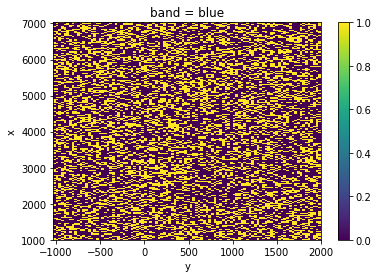

In [23]:
yp = gs.predict(X)
yp = yp.unstack("sample")
yp.plot.imshow()

In [24]:
# predict labels
yp = gs.predict(X)
yp.values = LabelEncoder().fit(X.land_use).classes_[yp]
yp = yp.unstack("sample")
print(yp)

<xarray.DataArray (x: 200, y: 100)>
array([['forest', 'water', 'forest', ..., 'forest', 'water', 'water'],
       ['water', 'forest', 'water', ..., 'water', 'forest', 'water'],
       ['water', 'water', 'water', ..., 'forest', 'forest', 'forest'],
       ...,
       ['water', 'forest', 'water', ..., 'forest', 'forest', 'forest'],
       ['water', 'forest', 'forest', ..., 'forest', 'water', 'forest'],
       ['water', 'forest', 'forest', ..., 'water', 'forest', 'forest']],
      dtype='<U6')
Coordinates:
    band      <U4 'blue'
    land_use  (x, y) <U6 'forest' 'water' 'forest' ... 'water' 'forest' 'forest'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
